In [66]:
from brian2 import *

In [67]:
# Passive properties
Diam = 8*umetre
Rm = 6000*ohm*cm**2
Cm = 1*uF*cm**-2
Ra = 200*ohm*cm
Leak_g = 4.97e-6*siemens*cm**-2

In [68]:
# Ionic current parameters
Ih_rev = -32*mV
Ikv_rev = -74*mV
Ikx_rev = -74*mV
Ica_rev = 40*mV

Ih_gbar = 2.5*msiemens*cm**-2
Ih_g = 1e-3*Ih_gbar
Ikv_g = 1e-3*msiemens*cm**-2
Ikx_g = 4e-4*msiemens*cm**-2
Ica_g = 5e-4*msiemens*cm**-2

Vhalf_h = -82*mV

Sh = -5.33*mV

aoh = 1*Hz

In [69]:
# Gating variable parameters
a1 = 0.3*ms**-1
b1 = 98*mV
c1 = 10*mV

a2 = 0.3*ms**-1
b2 = 30*mV
c2 = 20*mV

In [70]:
# Photocurrent parameters
Idark = -40*pA
Tau1 = 50*ms
Tau2 = 450*ms
Tau3 = 800*ms
RodB = 3800*ms

In [97]:
# Compartment model equations
eqs = '''
Ih = Ih_g * n * (V-Ih_rev) : amp / metre**2
Ikv = Ikv_g * (m**3) * h * (V-Ikv_rev) : amp / metre**2
Ikx = Ikx_g * n * (V-Ikx_rev) : amp / metre**2
Ica = Ica_g * n * (V-Ica_rev) : amp / metre**2

# input photocurrent
# Ip = Idark + A*( (1-exp(-t/Tau1)) - (1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3))): amp
# Why 32 and 33??
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp

# Transmembrane current
Im = 0*amp/metre**2 : amp / metre**2

dV/dt = -(Ih + Ikv + Ikx + Ica + Ip/(1e-6*metre**2) + Im) / Cm : volt

dm/dt = alpha * (1-m) - beta * m : 1
dn/dt = alpha * (1-n) - beta * n : 1
dh/dt = alpha * (1-h) - beta * h : 1

alpha = a1 / (1 + exp((V + b1)/c1)) : Hz
beta = a2 / (1 + exp(-(V + b2)/c2)) : Hz
'''

Text(0, 0.5, 'Voltage (mV)')

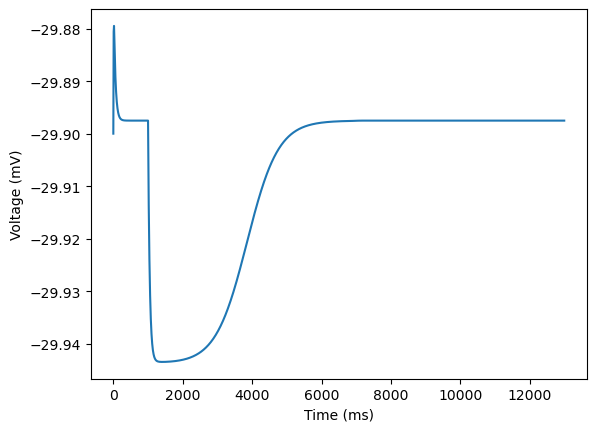

In [99]:
start_scope()
morpho = Cylinder(diameter=Diam, n=1, length=8*umetre)
neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ra, method='euler')
M = StateMonitor(neuron, 'V', record=True, dt=10*ms)
neuron.V = -29.9*mV
neuron.A = 0*pA
run(1000*ms)
neuron.A = 10*pA
run(6000*ms)
neuron.A = 0*pA
run(6000*ms)
plot(M.t/ms, M.V[0]/mV)
xlabel('Time (ms)')
ylabel('Voltage (mV)')

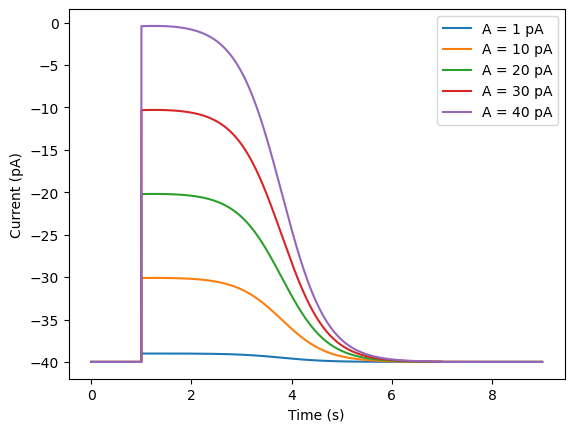

In [94]:
eqs = '''
# input photocurrent
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp
'''

# Simulate model in Brian2 with input A = 0.001nA
for input_amp in [1, 10, 20, 30, 40]:
    start_scope()
    G = NeuronGroup(1, eqs, method='euler')
    M = StateMonitor(G, 'Ip', record=True)
    G.A = 0*pA
    run(1000*ms)
    G.A = input_amp*pA
    run(6000*ms)
    G.A = 0*pA
    run(2000*ms)
    plot(M.t/second, M.Ip[0]/pA, label=f'A = {input_amp} pA')
    xlabel('Time (s)')
    ylabel('Current (pA)')
legend();

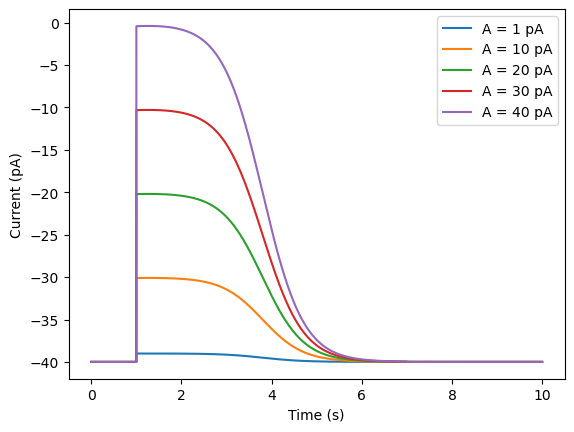

In [93]:
def photocurrent(t, A, Idark, Tau1, Tau2, Tau3, RodB):
    # return Idark + A*( (1-exp(-t/Tau1)) - (1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))
    Part1 = 32*( 1 - exp(-t/Tau1))
    Part2 = -33/(1+exp(-(t-RodB)/Tau2))
    Part3 = 1 - exp( -t/Tau3)
    return Idark + A*(Part1 + Part2 + Part3)/33

arr_t = np.arange(0, 10000, 1)*ms
for input_amp in [1, 10, 20, 30, 40]:
    arr_A = np.zeros(len(arr_t))*pA
    arr_A[1000:7000] = input_amp*pA
    pc = photocurrent(arr_t, arr_A, Idark, Tau1, Tau2, Tau3, RodB)
    
    plot(arr_t/second, pc/pA, label=f'A = {input_amp} pA')
    xlabel('Time (s)')
    ylabel('Current (pA)')
legend();